<a href="https://colab.research.google.com/github/Nisha0202/CSE366LAB07/blob/main/cse366lab07_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0073.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0040.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0030.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0062.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0020.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0044.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0023.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0050.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0041.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0047.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0070.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0036.jpg
/kaggle/input/modeltrainingg/101_ObjectCategories/scorpion/image_0017.jpg
/kaggle/input/modeltrainingg/101_Objec

**Installing library**

In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-ooixtk9x
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-ooixtk9x
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit fd4b5c863fbfc06b23d2d396413e08831c2c2ecf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=41821 sha256=d552678cacce50f2056cc5e967ca095daee9d9824cf53667d9dc1e11ebc72aa7
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qljpenc/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


In [ ]:
# Load Dataset
dataset = datasets.ImageFolder(root='/kaggle/input/modeltrainingg/101_ObjectCategories', transform=transform)

In [ ]:
# Debugging Dataset Labels
all_labels = [label for _, label in dataset]
print(f"Max label: {max(all_labels)}, Min label: {min(all_labels)}")

Max label: 101, Min label: 0


In [ ]:
# Split Dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
# Get the number of classes directly from the dataset
num_classes = len(dataset.classes)
print(num_classes)

102


**Pretrained Model**

In [ ]:
# VGG19 with Dropout
model_vgg19 = models.vgg19(pretrained=True)
model_vgg19.classifier[6] = nn.Linear(4096, num_classes)  # Adjust final layer for 102 classes
model_vgg19.classifier[5] = nn.Dropout(p=0.5)
model_vgg19 = model_vgg19.to(device)

In [ ]:
# ResNet50 with Dropout
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(2048, num_classes)  # Adjust final layer for 102 classes
)
model_resnet50 = model_resnet50.to(device)

In [ ]:
# EfficientNet-B0 with Dropout
model_efficientnet = models.efficientnet_b0(pretrained=True)
model_efficientnet.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(1280, num_classes)  # Adjust final layer for 102 classes
)
model_efficientnet = model_efficientnet.to(device)

In [ ]:
# Training Function with Weight Decay
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f} | Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_loss += loss.item()

    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f} | Validation Acc: {val_acc:.2f}%")
    return train_acc, val_acc

In [ ]:
# Define criterion and optimizer with weight decay
criterion = nn.CrossEntropyLoss()

**Training Accuracy and Loss**

In [ ]:
# VGG19
optimizer_vgg19 = optim.Adam(model_vgg19.parameters(), lr=0.0001, weight_decay=1e-4)  # Reduce learning rate and add weight decay
train_acc_vgg19, val_acc_vgg19 = train_model(model_vgg19, train_loader, val_loader, criterion, optimizer_vgg19)

Epoch 1/10 | Loss: 2.9123 | Acc: 36.62%
Epoch 2/10 | Loss: 1.7758 | Acc: 55.17%
Epoch 3/10 | Loss: 1.3705 | Acc: 64.18%
Epoch 4/10 | Loss: 1.1396 | Acc: 69.31%
Epoch 5/10 | Loss: 0.9895 | Acc: 72.96%
Epoch 6/10 | Loss: 0.8915 | Acc: 75.41%
Epoch 7/10 | Loss: 0.7835 | Acc: 77.57%
Epoch 8/10 | Loss: 0.7235 | Acc: 79.73%
Epoch 9/10 | Loss: 0.6661 | Acc: 81.42%
Epoch 10/10 | Loss: 0.6337 | Acc: 82.45%
Validation Loss: 0.8857 | Validation Acc: 76.59%


In [ ]:
# ResNet50
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.0001, weight_decay=1e-4)  # Reduce learning rate and add weight decay
train_acc_resnet50, val_acc_resnet50 = train_model(model_resnet50, train_loader, val_loader, criterion, optimizer_resnet50)

Epoch 1/10 | Loss: 2.5590 | Acc: 44.62%
Epoch 2/10 | Loss: 1.1770 | Acc: 70.38%
Epoch 3/10 | Loss: 0.8093 | Acc: 78.69%
Epoch 4/10 | Loss: 0.6654 | Acc: 82.34%
Epoch 5/10 | Loss: 0.5613 | Acc: 84.33%
Epoch 6/10 | Loss: 0.4922 | Acc: 86.06%
Epoch 7/10 | Loss: 0.4467 | Acc: 87.48%
Epoch 8/10 | Loss: 0.3769 | Acc: 89.45%
Epoch 9/10 | Loss: 0.3621 | Acc: 89.82%
Epoch 10/10 | Loss: 0.3267 | Acc: 90.65%
Validation Loss: 0.6070 | Validation Acc: 84.79%


In [ ]:
# EfficientNet-B0
optimizer_efficientnet = optim.Adam(model_efficientnet.parameters(), lr=0.0001, weight_decay=1e-4)  # Reduce learning rate and add weight decay
train_acc_efficientnet, val_acc_efficientnet = train_model(model_efficientnet, train_loader, val_loader, criterion, optimizer_efficientnet)

Epoch 1/10 | Loss: 3.7813 | Acc: 22.23%
Epoch 2/10 | Loss: 2.7130 | Acc: 43.12%
Epoch 3/10 | Loss: 1.9891 | Acc: 55.68%
Epoch 4/10 | Loss: 1.4599 | Acc: 66.63%
Epoch 5/10 | Loss: 1.1185 | Acc: 73.06%
Epoch 6/10 | Loss: 0.9002 | Acc: 77.92%
Epoch 7/10 | Loss: 0.7641 | Acc: 80.63%
Epoch 8/10 | Loss: 0.6285 | Acc: 83.17%
Epoch 9/10 | Loss: 0.5592 | Acc: 85.52%
Epoch 10/10 | Loss: 0.4882 | Acc: 87.18%
Validation Loss: 0.5366 | Validation Acc: 85.01%


In [ ]:
# Print results
print(f"VGG19 - Training Accuracy: {train_acc_vgg19:.2f}% | Validation Accuracy: {val_acc_vgg19:.2f}%")
print(f"ResNet50 - Training Accuracy: {train_acc_resnet50:.2f}% | Validation Accuracy: {val_acc_resnet50:.2f}%")
print(f"EfficientNet-B0 - Training Accuracy: {train_acc_efficientnet:.2f}% | Validation Accuracy: {val_acc_efficientnet:.2f}%")

VGG19 - Training Accuracy: 82.45% | Validation Accuracy: 76.59%
ResNet50 - Training Accuracy: 90.65% | Validation Accuracy: 84.79%
EfficientNet-B0 - Training Accuracy: 87.18% | Validation Accuracy: 85.01%


In [ ]:
# Part 5: Evaluating the Model
# Evaluate on Test Data
def evaluate_model(model, test_loader, class_names):
    model.eval()

    # Initialize lists to store true and predicted labels
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Debugging: Check number of unique classes in y_true and y_pred
    unique_y_true = set(y_true)
    unique_y_pred = set(y_pred)
    print(f"Number of unique classes in y_true: {len(unique_y_true)}")
    print(f"Number of unique classes in y_pred: {len(unique_y_pred)}")
    print(f"Unique classes in y_true: {unique_y_true}")
    print(f"Unique classes in y_pred: {unique_y_pred}")
    print(f"Class names: {class_names}")
    print(f"Number of class names: {len(class_names)}")

    # Ensure number of classes match
    assert len(unique_y_true) == len(class_names), "Mismatch between number of classes in y_true and class names"

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[class_names[i] for i in unique_y_true], zero_division=0))

    # Top-k Accuracy
    def top_k_accuracy(output, target, k=5):
        with torch.no_grad():
            max_k_preds = torch.topk(output, k, dim=1).indices
            correct = max_k_preds.eq(target.view(-1, 1).expand_as(max_k_preds))
        return correct.any(dim=1).float().mean().item()

    # Calculate top-5 accuracy for the entire test set
    all_top_5_acc = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            top_5_acc = top_k_accuracy(outputs, labels, k=5)
            all_top_5_acc.append(top_5_acc)
    overall_top_5_acc = sum(all_top_5_acc) / len(all_top_5_acc)
    print(f"Top-5 Accuracy: {overall_top_5_acc:.2f}")

    # Per-Class Accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(per_class_accuracy):
        print(f"Class {class_names[i]} Accuracy: {acc:.2f}")

    # t-SNE Visualization
    features = []
    labels_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu())
            labels_list.append(labels.cpu())
    features = torch.cat(features).numpy()
    labels_list = torch.cat(labels_list).numpy()
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_list, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=[class_names[i] for i in unique_y_true])
    plt.colorbar()
    plt.show()

In [ ]:
# Class names (adjust as needed)
class_names = dataset.classes

Evaluating VGG19
Number of unique classes in y_true: 102
Number of unique classes in y_pred: 101
Unique classes in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
Unique classes in y_pred: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
Class names: ['BACKGROUND_Google', 'Faces', 'Faces_ea

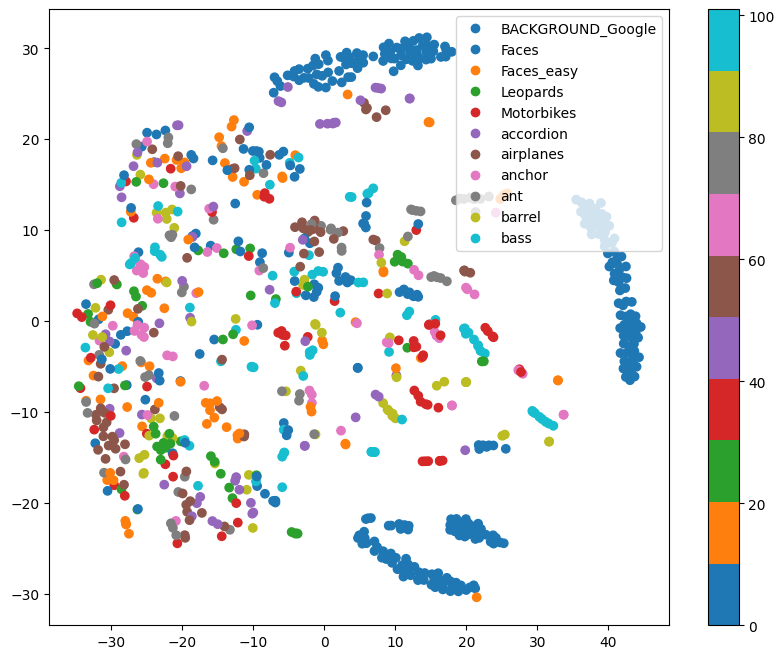

In [ ]:
# Evaluate VGG19
print("Evaluating VGG19")
evaluate_model(model_vgg19, test_loader, class_names)

Evaluating ResNet50
Number of unique classes in y_true: 102
Number of unique classes in y_pred: 101
Unique classes in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
Unique classes in y_pred: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101}
Class names: ['BACKGROUND_Google', 'Faces', 'Faces

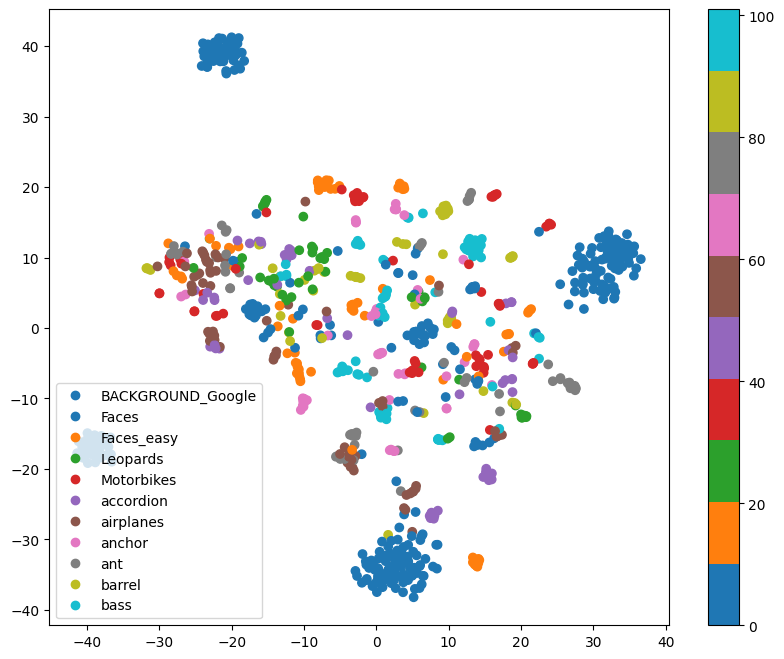

In [ ]:
# Evaluate ResNet50
print("Evaluating ResNet50")
evaluate_model(model_resnet50, test_loader, class_names)

Evaluating EfficientNet-B0
Number of unique classes in y_true: 102
Number of unique classes in y_pred: 102
Unique classes in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
Unique classes in y_pred: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
Class names: ['BACKGROUND_Google', 'Fac

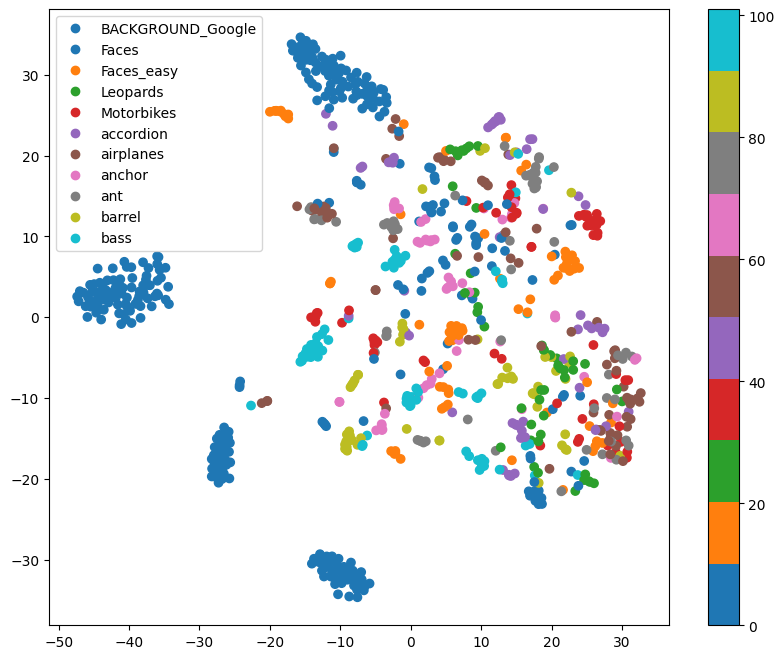

In [ ]:
# Evaluate EfficientNet-B0
print("Evaluating EfficientNet-B0")
evaluate_model(model_efficientnet, test_loader, class_names)

**Grad-CAM Visualization**

In [ ]:
# Grad-CAM Visualization Function
def grad_cam_visualization(model, test_loader, target_layer):
    model.eval()  # Set model to evaluation mode
    cam = GradCAM(model=model, target_layers=[target_layer])
    images_processed = 0

    plt.figure(figsize=(15, 10))
    for images, labels in test_loader:
        images = images.to(device)
        grayscale_cams = cam(input_tensor=images)

        for idx in range(images.size(0)):
            # Denormalize image
            img = images[idx].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize the image
            img = np.clip(img, 0, 1)

            cam_image = show_cam_on_image(img, grayscale_cams[idx], use_rgb=True)

            plt.subplot(5, 2, 2*images_processed+1)
            plt.imshow(img)
            plt.title(f"True: {dataset.classes[labels[idx]]}")
            plt.axis('off')

            plt.subplot(5, 2, 2*images_processed+2)
            plt.imshow(cam_image)
            plt.title("Grad-CAM")
            plt.axis('off')

            images_processed += 1
            if images_processed >= 5:
                plt.tight_layout()
                plt.show()
                return

Grad-CAM for VGG19


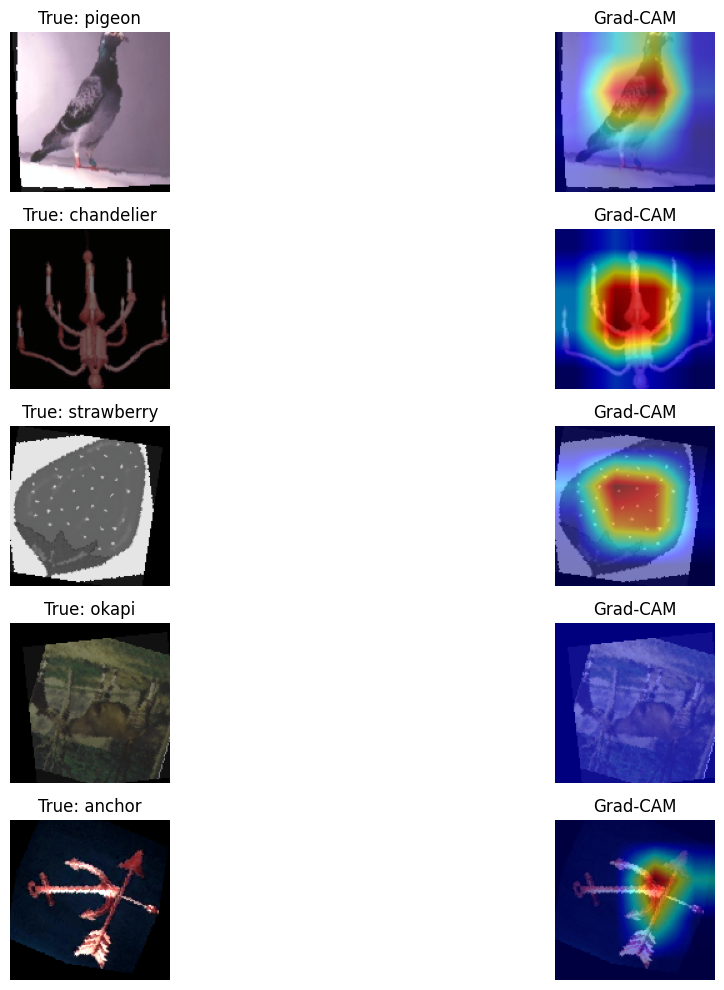

In [ ]:
# Visualize Grad-CAM for VGG19
print("Grad-CAM for VGG19")
grad_cam_visualization(model_vgg19, test_loader, target_layer=model_vgg19.features[-1])

Grad-CAM for ResNet50


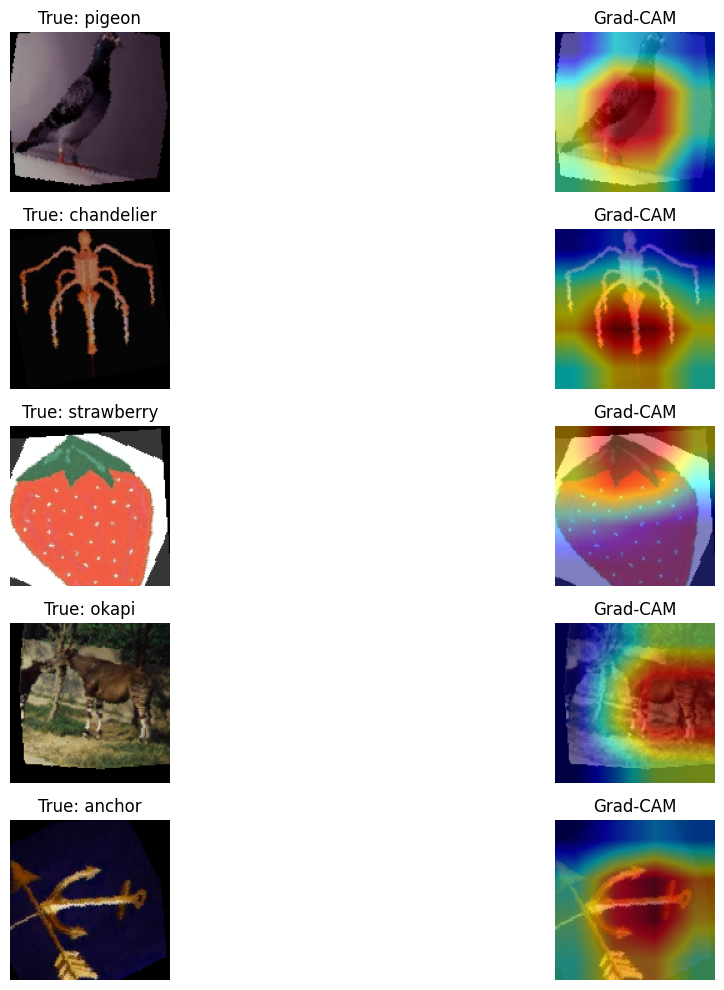

In [ ]:
# Visualize Grad-CAM for ResNet50
print("Grad-CAM for ResNet50")
grad_cam_visualization(model_resnet50, test_loader, target_layer=model_resnet50.layer4[-1])

Grad-CAM for EfficientNet-B0


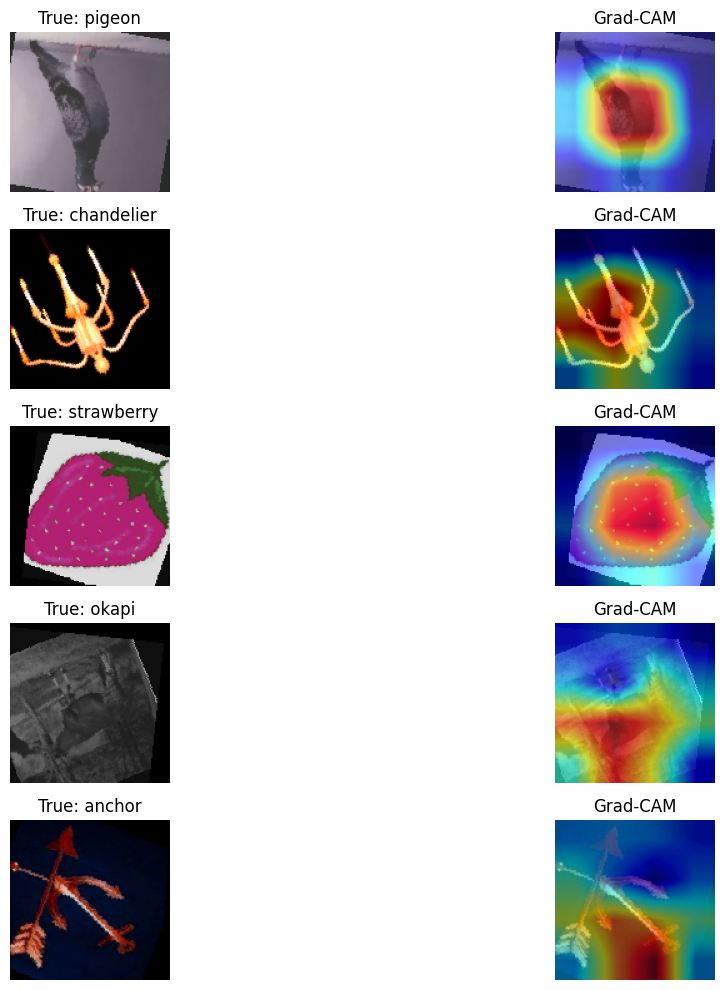

In [ ]:
# Visualize Grad-CAM for EfficientNet-B0
print("Grad-CAM for EfficientNet-B0")
grad_cam_visualization(model_efficientnet, test_loader, target_layer=model_efficientnet.features[-1])